In [5]:
# If You use in Colab, You Should run this script
import os
if (not os.path.exists("./SSD-object-detection") and
    not "SSD-object-detection" in os.getcwd()):
    !git clone https://github.com/public-ai/SSD-object-detection.git
os.chdir("./SSD-object-detection")

Cloning into 'SSD-object-detection'...
remote: Enumerating objects: 167, done.
remote: Counting objects: 100% (167/167), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 167 (delta 96), reused 162 (delta 91), pack-reused 0
Receiving objects: 100% (167/167), 26.35 MiB | 20.32 MiB/s, done.
Resolving deltas: 100% (96/96), done.


In [6]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9681 sha256=f6b7fd114a1b4b1fb71a3d00031014ab8a1b54ffbd172b7c64a38984f7a8cb78
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [7]:
%matplotlib inline

import sys
sys.path.append("../")
from utils import DetectionDataset
from utils import draw_rectangle
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

np.random.seed(10)

# \[ SSD Prior Boxes \]
----
----

![Imgur](https://i.imgur.com/ztgXQQO.png)


우리는 각 Feature Map 마다 가상의 box인 Prior Box를 둡니다. 이 Prior Box는 Multi-Head Network가 물체를 잡을 때 기준이 되는 Box로, Prior Box에 물체가 Threhold 이상 겹쳤을 때에만 동작하도록 구성됩니다. SSD 모델은 각 Layer 별로 Prior Box를 두어, Multi Scale의 이미지에 동작할 수 있도록 구현되어 있습니다.

## 1. DetectionDataset 가져오기
---

무작위로 300개 가량의 이미지를 불러오도록 하겠습니다. 영상 내 존재하는 글자들의 크기가 대략 얼마만큼 되는지를 파악해보도록 하겠습니다.

### (1) Dataset 불러오기

In [0]:
dataset = DetectionDataset(data_type='validation')
images, ground_truths = dataset[0:300]

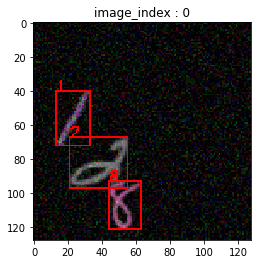

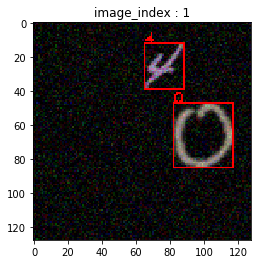

In [9]:
num_show = 2
for image, (image_index, gt_df) in zip(images, ground_truths.groupby('image_index')):
    vis_image = draw_rectangle(image, gt_df)
    plt.title(f"image_index : {image_index}")
    plt.imshow(vis_image)
    plt.show()

    if num_show <=1:
        break
    num_show-=1

### (2) 글자 폭과 높이의 분포 확인하기

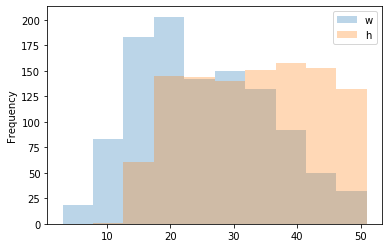

In [10]:
ground_truths[['w','h']].plot(kind='hist', alpha=0.3)
plt.show()

대부분의 박스가 10~50 사이에 위치하게 됩니다. Default Box의 크기(Scale)를 10, 25, 40으로 두도록 하겠습니다.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='hist')` instead of `Series.plot('hist',)`.
  """Entry point for launching an IPython kernel.


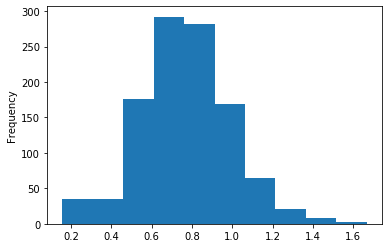

In [11]:
(ground_truths.w/ground_truths.h).plot('hist')
plt.show()

글자의 가로/세로 비율($\frac{width}{height}$)은 0.2~1.6까지 분포합니다.

## 2. Prior Box 구성하기
----

![Imgur](https://i.imgur.com/ztgXQQO.png)

### (1) Prior Box의 크기 산정하기


우리는 위에서 Prior box의 Scale은 $[10,25,40]$로 두고, Prior Box의 Ratio은 $ [(1,1),(1.5,0.5),(1.2,0.8),(0.8,1.2),(1.4,1.4)]$로 두었습니다. Scale은 각 Source Layer에 매칭됩니다. 얕은 층의 Source Layer는 영상에서 세밀한 정보를 가지고 있고, 깊은 층의 Source Layer은 영상에서 전체적인 정보를 가지고 있습니다. 그렇기 때문에 작은 사물을 잡을 때에는 얕은 층의 Layer가 유리하고, 큰 사물을 잡을 때에는 깊은 층의 Layer가 유리합니다.

In [0]:
strides = [4, 8, 16]
scales = np.array([10, 25, 40])
ratios = np.array([(1,1),     # ratio : 1.
          (0.5,1.5), # ratio : 0.33
          (0.8,1.2), # ratio : 0.67
          (1.2,0.8), # ratio : 1.5
          (1.4,1.4)])

"""
Question. 1
코드를 한줄만 사용해 각 ratio 와 scales 이 곱해진 matrix 을 생성하세요.

정답:
array([[[10. , 10. ],
        [ 5. , 15. ],
        [ 8. , 12. ],
        [12. ,  8. ],
        [14. , 14. ]],

       [[25. , 25. ],
        [12.5, 37.5],
        [20. , 30. ],
        [30. , 20. ],
        [35. , 35. ]],

       [[40. , 40. ],
        [20. , 60. ],
        [32. , 48. ],
        [48. , 32. ],
        [56. , 56. ]]])
제한 시간 10분
"""
# Fix me! 

### (2) Feature Map의 각 점에 Prior Box 배치하기

위에서 주어진 Default box의 Feature Map이 아래와 같이 주어지게 됩니다.

In [0]:
"""
Question. 2
feature map (8, 8), strides 16, 
w,h =([[40., 40.],
       [20., 60.],
       [32., 48.],
       [48., 32.],
       [56., 56.]])
에 대해 prior boxes(anchor boxes) 을 구성해 주세요.
제한 시간 30분
"""

h = 8
w = 8
stride = 16
ind = 2

# fix me!

In [ ]:
"""
Question. 3
위 코드를 function 으로 만들어 주세요.
# 제한 시간 5분 

Example)
def generate_anchors(fmap_h, fmap_w, stride, scaled_ratios):
    return anchors 

"""

def generate_anchors(fmap_h, fmap_w, stride, achr_sizes):
    #fix me!

    return anchors

In [ ]:
"""
Question. 4
위 만든 generate_anchors 을 이용해 
feature map 이 (32,32), (16,16), (8,8) 일 때 적절한 anchors 을 생성한 후 
axis =0 으로 concat 한 anchors 을 return 해 주세요.


all_anchors.shape 은 (6720, 4) 이 나와야 합니다.
# 제한 시간 5분 
"""

all_anchors = # fix me!

위의 정보를 시각화하면 아래와 같습니다. 행 방향으로는 Head Network의 순서대로, 열 방향으로는 Prior Ratio의 순서대로 구성하였습니다.

In [0]:
"""
Question. 5
cx cy w h 좌표계를 x1 y1 x2 y2 좌표계로 변경 하는 함수를 생성하세요.
# 제한 시간 5분 
"""
def ccwh2xyxy(ccwh):
    return # fix me!

In [0]:
# 복수개의 x1 y1 x2 y2 좌표계가 들어왔을 때 이미지에 모두 그리는 함수
# 제한 시간 5분 
def show_boxes(image, boxes):
    image = image.copy()
    for x1, y1, x2, y2 in boxes:
        cv2.rectangle(image, (x1, y1), (x2, y2), (255,0,0), 1)
    plt.imshow(image)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


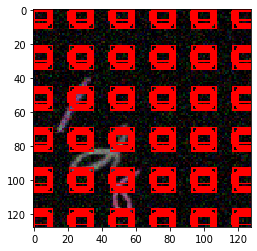

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


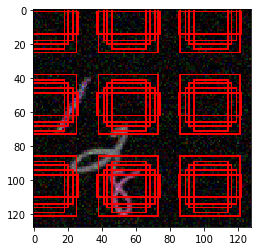

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


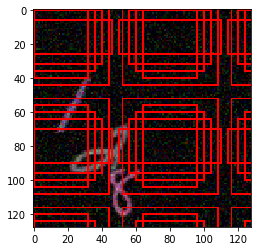

In [16]:
"""
아래 코드를 실행해 주세요
"""

# Sample Imaget 
sample_image = images[0].copy()

# Boxes 
h = 32
w = 32
stride = 8
sample_boxes = generate_anchors(h, w, stride, scaled_ratios[0])
sample_boxes = sample_boxes.reshape(h, w, -1, 4)
sample_boxes = sample_boxes[::3, ::3, :, :]    

sample_boxes = sample_boxes.reshape(-1, 4)
sample_boxes = ccwh2xyxy(sample_boxes).astype(np.int32)
show_boxes(sample_image, sample_boxes)


# 
h = 16
w = 16
stride = 16
sample_boxes = generate_anchors(h, w, stride, scaled_ratios[1])
sample_boxes = sample_boxes.reshape(h, w, -1, 4)
sample_boxes = sample_boxes[::3, ::3, :, :]    

sample_boxes = sample_boxes.reshape(-1, 4)
sample_boxes = ccwh2xyxy(sample_boxes).astype(np.int32)
show_boxes(sample_image, sample_boxes)


h = 8
w = 8
stride = 32
sample_boxes = generate_anchors(h, w, stride, scaled_ratios[2])
sample_boxes = sample_boxes.reshape(h, w, -1, 4)
sample_boxes = sample_boxes[::2, ::2, :, :]    

sample_boxes = sample_boxes.reshape(-1, 4)
sample_boxes = ccwh2xyxy(sample_boxes).astype(np.int32)
show_boxes(sample_image, sample_boxes)




위의 작업을 클래스로 구현하면 아래와 같이 됩니다.

In [0]:
import numpy as np
"""
Question. 6
위 prior 만드는 코드를 class 로 작성하세요. 
# 제한 시간 30분 
"""
class PriorBoxes:
    def __init__(self, strides, scales, ratios):
        self.strides = strides
        self.scales = scales  # [10, 25, 40]
        self.ratios = ratios
        self.config = {
            "strides": self.strides,
            "scales": self.scales,
            "ratios": self.ratios
        }
        """

        example)
        strides = [4, 8, 16]
        scales => [10, 25, 40] 
        ratios => [(1  ,1),
                   (1.5,0.5),
                   (1.2,0.8),
                   (0.8,1.2),
                   (1.4,1.4)]
        """
    def generate(self, image_shape):
        """
        image_shape(H,W,3)에 맞춰서, Prior Box(==Default Boxes)를 생성하는 코드

        return :
        (# Prior Boxes, 4)로 이루어진 출력 값 생성
        """
        # fix me!
        
        return total_anchors

## 3. Matching Strategy 구현하기
----

우리는 학습을 시킬 때, Prior Box가 최소 50%이상 겹친 박스에 대해서만, 사물이 있다고 판정하고 학습을 시킵니다. 50% 미만으로 겹친 박스들은 전부 Background라고 판정합니다. 우리는 Prior Box와 사물이 있는 박스를 위미하는 Ground Truth Box를 각각 서로 얼마나 겹치는지를 계산해야 합니다. 

![Imgur](https://i.imgur.com/mnlYIBL.png)

우리는 위와 같이 $(x_{min},y_{min},x_{max},y_{max})$을 가지고 겹친 넓이를 구할 수 있습니다.

In [18]:
np.random.seed(10) # 결과가 같도록 고정
image, ground_truths = dataset[0]

gt_boxes = ground_truths.iloc[:,1:5].values
gt_labels = ground_truths.iloc[:,-1].values

print("gt boxes의 shape : ", gt_boxes.shape)
gt_boxes

gt boxes의 shape :  (3, 4)


array([[ 23. ,  56. ,  20. ,  32. ],
       [ 38. ,  82. ,  34. ,  30. ],
       [ 53.5, 107. ,  19. ,  28. ]])

![Imgur](https://i.imgur.com/lXNlMmc.png)

### (1) Pivot Bounding Boxes

우리는 동시에 GT Boxes와 Prior Boxes의 IOU를 계산하기 위해서는 우선 두 벡터(`gt_boxes`,`pr_boxes`)를 Pivot해주어야 합니다.

![Imgur](https://i.imgur.com/xBFzmhW.png)

### (2) Calculate Intersection Over Union

그리고 우리는 이제 전체 면적 중 얼마나 겹쳤는지를 의미하는 IoU(Intersection Over Union)을 계산해야 합니다.<br>
수식은 아래와 같습니다.

![Imgur](https://i.imgur.com/B5Y0Erv.png)

![Imgur](https://i.imgur.com/w01apzz.png)

In [0]:
"""
Question. 7
Ground Truths 와 Prior boxes(anchor boxes) 와 iou 을 계산하는 함수 코드를 작성하세요.
return shape 는 (N_anchors, N_gt) 입니다.

# 제한 시간 30분 
"""
def calculate_iou(pr_boxes, gt_boxes):
    # fix me!
    
    return iou

위의 알고리즘을 메소드로 구현하면 아래와 같습니다.

위의 로직을 통해, prior boxes와 ground truth boxes가 겹치는 갯수는 아래와 같습니다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


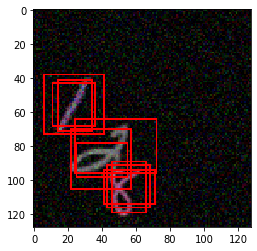

In [20]:
"""
Question. 8
IOU 을 계산 후 IOU가 0.5 이상되는 anchor 을 찾아 Image 에 그려주세요.
- hint : 위 작성한 ccwh2xyxy, show_boxes 사용 
# 제한 시간 30분 
"""

# fix me!


빨간색은 `gt_boxes`이고, 파란색과 노란색은 `pr_boxes`입니다. 파란 색은 `pr_boxes` 중 matching 되지 못한 것, 노란 색은 `pr_boxes` 중 Matching 된 것입니다.

## 3. Training Objective 구성하기
----

우리의 목표는 Matching된 Prior Box에 있는 숫자를 `multi-box head Network`로<br>
(1) 어떤 숫자인지 파악하고 (2) 숫자의 위치가 어디에 있는지를 파악하는데에 이용하고자 합니다.

즉 모델에서 예측하고자 하는 출력의 형태로 우리는 바꾸어 주어야 합니다.

In [21]:
from models.ssd import build_base_network, attach_multibox_head

base_network = build_base_network(input_shape=(None,None,3),
                                  num_units=16)
predictions = attach_multibox_head(base_network,
                                   ['norm3_2', 'norm4_2', 'norm5_2']) 
model = Model(base_network.input, predictions)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### (1) Classification Network의 정답 구성하기

우리는 match_indices에 포함된 것들 제외하고는 모두 Background로 라벨링을 해주어야 합니다.

In [0]:
from tensorflow.keras.utils import to_categorical

In [0]:
"""
Question. 9

classification 에 사용될 trues(y값) 을 만들어주세요. 
최종 shape 는 [N_anchors , N_classes] 형태가 되어야 합니다.

아래 주석에 따라 코딩을 진행해 주세요!

# 제한 시간 30분 
"""

gt_labels = ground_truths.iloc[:,-1].values

# background 로 모두 라벨링 되어 있고 shape 가 [N_anchors , N_classes] 인 matrix 을 생성해주세요.
# fix me!

# positive 인 anchors 의 labels 을 가져와주세요.
# fix me!

# pos_label 을 onehot 으로 바꿔주세요.
# fix me!

# positive 인 anchors 의 index 을 가져와주세요. 
# fix me!

# cls_trues 에 positive 인 anchor의 classification 정보를 넣어주세요.
# fix me!

In [24]:
"""
Question. 10

위 기능을 함수로 만들어 주세요.
# 제한 시간 30분 
"""

def generate_cls_trues(gt_labels, match_indices, n_classes, bg_index):
    # fix me!
    return cls_trues


cls_trues = generate_cls_trues(gt_labels, match_indices, 11, 10)
print(cls_trues)

[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


### (2) Localization Network의 정답 구성하기

Localization Network는 Prior Box내에 있는 사물의 위치를 보정하여 줍니다. 보정 수식은 아래와 같습니다.<br>
$
y_{true}^{loc} = (\hat g^{cx},\hat g^{cy}, \hat g^{w},\hat g^{h}) \\
\hat g^{cx} = \frac{(g^{cx} - p^{cx})}{p^{w}} \\
\hat g^{cy} = \frac{(g^{cy} - p^{cy})}{p^{h}} \\
\hat g^{w} = log(\frac{g^{w}}{p^{w}}) \\
\hat g^{h} = log(\frac{g^{h}}{p^{h}}) \\
$

In [0]:
"""
Question. 11

positive anchor 을 ground truth 정보를 이용해 보정합니다.
그리고 localization(detection) 에 사용될 label을 생성합니다.
아래 주석에 따라 코딩을 진행해 주세요!

# 제한 시간 20분 
"""


# positive anchor와 matching 되는 ground truths 값을 가져옵니다.
# fix me!

# positive anchor 을 가져옵니다.
# fix me!

# delta 값 구하기 
# fix me!

# delta 값 stack 하기 , axis=-1 축으로 
# fix me!

# Shape 가 [N_anchor , 4] 이고 값이 모두 0으로 채워진 matrix 만들기 
# fix me!

In [28]:
"""
Question. 12

위 기능을 함수로 만들어 주세요.
# 제한 시간 30분 
"""

def generate_loc_trues(gt_boxes, pr_boxes, match_indices, n_classes, bg_index):
    # fix me!

    return loc_trues
loc_trues = generate_loc_trues(gt_boxes, all_anchors, match_indices, 11, 10)
print(loc_trues)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 ...
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


이후에 이 값을 복원하기 위해서는 아래 수식을 이용하면 됩니다.<br>

$
cx_{restore} = \hat g^{cx} * d^w +d^{cx} \\
cy_{restore} = \hat g^{cy} * d^h +d^{cy} \\
w_{restore} = exp^{\hat g^{w}} * d^w \\
h_{restore} = exp^{\hat g^{h}} * d^h \\
$

In [27]:
# 복원 후 동일한지 확인하기
res_cx = # fix me!
res_cy = # fix me!
res_w = # fix me!
res_h = # fix me!

restore_boxes = np.stack([res_cx,res_cy,res_w,res_h], axis=-1)

np.testing.assert_array_almost_equal(gt_boxes[match_indices[:,0]],
                                     restore_boxes[match_indices[:,1]])

SyntaxError: ignored

### (3) SSD Network의 정답값 구성하기

In [28]:
"""
Question. 14

axis -1 로 classification 정보와 localization 정답 정보를 합칩니다.
# 제한 시간 1분 
"""
# fix me!

(6720, 15)


---
⊙ Copyright(c) 2020 by PublicAI. All rights reserved <br>
All pictures, codes, writings cannot be copied without permission. <br>
Writen by PAI(info@publicai.co.kr) <br>
last updated on 2020/01/4 <br>

---